## Using pre-trained NN

In [1]:
#i dont use anaconda
!conda install -y nomkl > tmp.log

/bin/sh: conda: command not found


In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import six.moves.cPickle as pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
#from scipy.misc import imread, imsave, imresize # we will use opencv instead
from lasagne.utils import floatX

# Model Zoo
* https://github.com/Lasagne/Recipes/tree/master/modelzoo
* More models within the community
* Pick model, copy init, download weights
* Here we proceed with vgg16

In [ ]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

In [109]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [ ]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl', 'rb'))
#for example, 10th class is ostrich:
print(classes[9])

You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, vgg19 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [4]:

MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:,:,::-1]
    
    img = img - MEAN_VALUES
    
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return img

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [41]:
net = build_model()

In [9]:
import pickle
with open('vgg16.pkl', 'rb') as f:
    weights = pickle.load(f, encoding='latin1')  
    
all_params = weights['param values']
lasagne.layers.set_all_param_values(net['prob'], all_params)

In [10]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image)
prob = theano.function([input_image], output) 

### Sanity check
Давайте проверим, что загруженная сеть работает. Для этого мы скормим ей картину альбатроса и проверим, что она правильно его распознаёт

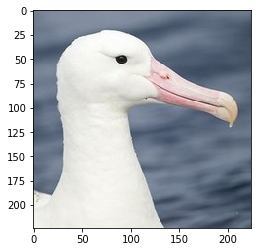

top-5 classes are:
0.995364	albatross
0.004630	goose
0.000003	drake
0.000002	American egret
0.000000	pelican


In [19]:
img = imread('./albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))
    

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [10]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X = []
Y = []

'''
#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
    features = get_features(img)
    Y.append(y)
    X.append(features)
'''    

'\n#this may be a tedious process. If so, store the results in some pickle and re-use them.\nfor fname in tqdm(os.listdir(\'train/\')):\n    y = fname.startswith("cat")\n    img = imread("train/"+fname)\n    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))\n    features = get_features(img)\n    Y.append(y)\n    X.append(features)\n'

In [11]:
#"I get by with a little help from my friends" - Beatles (use friends pickle)
#No further dimension  flattening is needed
X = np.load('./X_file.npy')
Y = np.load('./Y_file.npy')

In [12]:
print(X.shape)
print(Y.shape)

(25000, 4096)
(25000,)


In [35]:
'''
X = np.concatenate(X) #stack all [1xfeature] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]
'''

'\nX = np.concatenate(X) #stack all [1xfeature] matrices into one. \nassert X.ndim==2\n#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.\n\n#crop if we ended prematurely\nY = Y[:len(X)]\n'

In [13]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [14]:
#small check of sizes
print(len(Y_train), len(Y_val), len(Y_test))
print(X_train.shape, Y_train.shape)

18750 3125 3125
(18750, 4096) (18750,)


In [15]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#lets add a calibrated classifier for  CV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss


In [16]:
# Train random forest classifier, calibrate on validation data and evaluate
# on test data
random_forest = RandomForestClassifier(n_estimators = 25)
random_forest.fit(X_train, Y_train)
random_forest_probs = random_forest.predict_proba(X_test)
CV_random_forest = CalibratedClassifierCV(random_forest, method="sigmoid", cv="prefit")
CV_random_forest.fit(X_val, Y_val)
CV_random_forest_probs = CV_random_forest.predict_proba(X_test)
CV_random_forest_score = log_loss(Y_test, CV_random_forest_probs)

In [17]:
print(CV_random_forest_score)
print(CV_random_forest.score(X_test,Y_test))

0.0516113622938
0.98048


In [18]:
extra_tree = ExtraTreesClassifier(n_estimators = 25)
extra_tree.fit(X_train, Y_train)
extra_tree_probs = extra_tree.predict_proba(X_test)
CV_extra_tree = CalibratedClassifierCV(extra_tree, method="sigmoid", cv="prefit")
CV_extra_tree.fit(X_val,Y_val)
CV_extra_tree_probs = CV_extra_tree.predict_proba(X_test)
CV_extra_tree_score = log_loss(Y_test, CV_extra_tree_probs)

print(CV_extra_tree_score)
print(CV_extra_tree.score(X_test,Y_test))

0.0497074111679
0.9808


In [ ]:
boosted = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
boosted.fit(X_train, Y_train)
boosted_probs = boosted.predict_proba(X_test)
CV_boosted = CalibratedClassifierCV(boosted, method="sigmoid", cv="prefit")
CV_boosted.fit(X_val,Y_val)
CV_boosted_probs = CV_boosted.predict_proba(X_test)
CV_boosted_score = log_loss(Y_test, CV_boosted_probs)

In [24]:
print(CV_boosted_score)
print(CV_boosted.score(X_test,Y_test))

0.0969747987112
0.96256


# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [1]:
print("easy")

easy


In [2]:
#this construct was used as a part of different kaggle kernel suggestions.

import cv2                 # for resizing purposes
import numpy as np         
import os                  # for using directories
from random import shuffle # mixing
from tqdm import tqdm   

TRAIN_DIR = './train'
TEST_DIR = './test'
IMG_SIZE = 100
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '3conv-basic') # just so we remember which saved model is which, sizes must match

In [3]:
def label_to_hot(img):
    word_label = img.split('.')[0]
    # conversion to one-hot array [cat,dog]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [4]:
def train_data_load():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_to_hot(img)
        path  = os.path.join(TRAIN_DIR,img)
        img   = cv2.imread(path,cv2.IMREAD_COLOR)     #lets experiment with colours
        img   = cv2.resize(img,(IMG_SIZE,IMG_SIZE))   #resizing for our size
        img   = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        training_data.append([np.array(img),np.array(label)])
        
    shuffle(training_data)
    #np.save('train_data.npy', training_data)
    return training_data

#same function for testing
#actually this can be done in 1 function but im lazy now
def test_data_load():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        img   = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    #np.save('test_data.npy', testing_data)
    return testing_data


Populating the interactive namespace from numpy and matplotlib


/Users/Erik/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
  0%|          | 0/25000 [00:00<?, ?it/s]

./train/cat.0.jpg


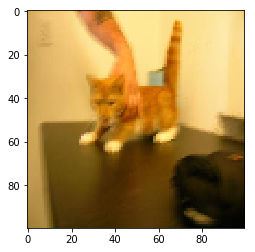

  0%|          | 1/25000 [00:00<2:50:10,  2.45it/s]

./train/cat.1.jpg


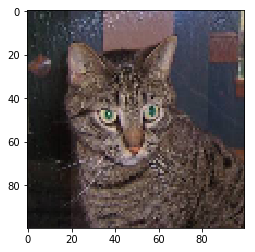

  0%|          | 2/25000 [00:00<2:21:44,  2.94it/s]

./train/cat.10.jpg


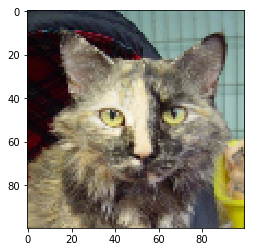

  0%|          | 3/25000 [00:00<2:01:53,  3.42it/s]

./train/cat.100.jpg


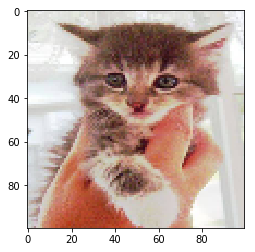

  0%|          | 4/25000 [00:00<1:48:54,  3.83it/s]


In [5]:
#small check to see if the paths work
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
i = 0;
for img in tqdm(os.listdir(TRAIN_DIR)):
    i +=1
    if(i>4):
        break
    path = os.path.join(TRAIN_DIR,img)
    print(path)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    img   = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(img)
    plt.show()


In [6]:
train_data = train_data_load()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')


100%|██████████| 25000/25000 [03:32<00:00, 117.64it/s]


In [7]:
#Warning this takes really really long and might even crash
#np.save('train_data.npy', train_data)
import time

In [8]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


In [9]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, 100, 100, 3], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 128, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Scipy not supported!


In [10]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [11]:
print(convnet.shape)

(?, 2)


In [12]:
train, validate, test = np.split(train_data, [int(.6*len(train_data)), int(.8*len(train_data))])

In [13]:
X_train = np.array([i[0] for i in train]).reshape(-3,IMG_SIZE,IMG_SIZE,3)
Y_train = [i[1] for i in train]

X_val   = np.array([i[0] for i in validate]).reshape(-3,IMG_SIZE,IMG_SIZE,3)
Y_val   = [i[1] for i in validate]

X_test = np.array([i[0] for i in test]).reshape(-3,IMG_SIZE,IMG_SIZE,3)
Y_test = [i[1] for i in test]

Y_train = np.asarray(Y_train)
Y_val   = np.asarray(Y_val)
Y_test  = np.asarray(Y_test)

In [14]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(Y_train.shape)

(15000, 100, 100, 3)
(5000, 100, 100, 3)
(5000, 100, 100, 3)
(15000, 2)


In [15]:
model.fit({'input': X_train}, {'targets': Y_train}, n_epoch=2, validation_set=({'input': X_test}, {'targets': Y_test}), 
    snapshot_step=1000, show_metric=True, run_id=MODEL_NAME)

Training Step: 469  | total loss: 11.62581 | time: 148.313s
| Adam | epoch: 002 | loss: 11.62581 - acc: 0.4951 -- iter: 14976/15000
Training Step: 470  | total loss: 11.75844 | time: 170.113s
| Adam | epoch: 002 | loss: 11.75844 - acc: 0.4893 | val_loss: 11.25043 - val_acc: 0.5114 -- iter: 15000/15000
--


In [23]:
model.save(MODEL_NAME)

INFO:tensorflow:/Users/Erik/Documents/ML/CATS vs DOGS/dogsvscats-0.001-3conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [43]:
test_data = test_data_load()

100%|██████████| 12500/12500 [01:53<00:00, 110.34it/s]


In [40]:
#this was transferred into a function later on
def write():
    with open('submission_file2.csv','w') as f:
        f.write('id,label\n')

    with open('submission_file2.csv','a') as f:
        for data in tqdm(test_data):
            img_num = data[1]
            img_data = data[0]
            orig = img_data
            data = img_data.reshape(IMG_SIZE,IMG_SIZE,3)
            model_out = model.predict([data])[0]
            f.write('{},{}\n'.format(img_num,model_out[1]))

Doesnt really look that much promising

In [19]:
import tensorflow as tf
tf.reset_default_graph() #reset for new net

In [20]:
def build_model()

    convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 3], name='input')

    convnet = conv_2d(convnet, 32, 5, activation='relu')
    convnet = max_pool_2d(convnet, 5)

    convnet = conv_2d(convnet, 64, 5, activation='relu')
    convnet = max_pool_2d(convnet, 5)

    convnet = conv_2d(convnet, 32, 5, activation='relu')
    convnet = max_pool_2d(convnet, 5)

    convnet = conv_2d(convnet, 64, 5, activation='relu')
    convnet = max_pool_2d(convnet, 5)

    convnet = conv_2d(convnet, 32, 5, activation='relu')
    convnet = max_pool_2d(convnet, 5)

    convnet = conv_2d(convnet, 64, 5, activation='relu')
    convnet = max_pool_2d(convnet, 5)

    convnet = fully_connected(convnet, 1024, activation='relu')
    convnet = dropout(convnet, 0.5)

    convnet = fully_connected(convnet, 2, activation='softmax')
    convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

    model = tflearn.DNN(convnet, tensorboard_dir='log')
    
    return model

In [22]:
model.fit({'input': X_train}, {'targets': Y_train}, n_epoch=5, validation_set=({'input': X_test}, {'targets': Y_test}), 
    snapshot_step=1000, show_metric=True, run_id=MODEL_NAME)

Training Step: 1180  | total loss: 0.35418 | time: 171.959s
| Adam | epoch: 006 | loss: 0.35418 - acc: 0.8424 -- iter: 14976/15000
Training Step: 1181  | total loss: 0.34912 | time: 193.171s
| Adam | epoch: 006 | loss: 0.34912 - acc: 0.8410 | val_loss: 0.43937 - val_acc: 0.8130 -- iter: 15000/15000
--


In [28]:
#lets go with more rounds

model.fit({'input': X_train}, {'targets': Y_train}, n_epoch=15, validation_set=({'input': X_test}, {'targets': Y_test}), 
    snapshot_step=1000, show_metric=True, run_id=MODEL_NAME)

Training Step: 4705  | total loss: 0.08344 | time: 150.145s
| Adam | epoch: 021 | loss: 0.08344 - acc: 0.9698 -- iter: 14976/15000
Training Step: 4706  | total loss: 0.08687 | time: 171.088s
| Adam | epoch: 021 | loss: 0.08687 - acc: 0.9665 | val_loss: 0.72702 - val_acc: 0.8224 -- iter: 15000/15000
--


In [29]:
model.save(MODEL_NAME) #overwrite for the better model

INFO:tensorflow:/Users/Erik/Documents/ML/CATS vs DOGS/dogsvscats-0.001-3conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [45]:
write()

100%|██████████| 12500/12500 [01:12<00:00, 173.47it/s]


[ 0.01617298  0.98382699]
[  5.02295370e-05   9.99949813e-01]
[ 0.10526917  0.89473081]
[ 0.99637383  0.00362614]
[  9.99976754e-01   2.32766761e-05]
[ 0.05062631  0.94937366]
[  3.62629535e-08   1.00000000e+00]
[ 0.45209071  0.54790926]
[  9.99913573e-01   8.63669411e-05]
[  9.99911547e-01   8.84607725e-05]
[ 0.93193853  0.06806146]
[  9.99995708e-01   4.32780098e-06]
[  8.59528910e-08   9.99999881e-01]
[  1.54279432e-12   1.00000000e+00]
[  5.41640732e-10   1.00000000e+00]
[  9.99711096e-01   2.88879819e-04]


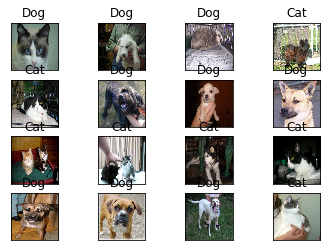

In [42]:
import matplotlib.pyplot as plt

# if you need to create the data:
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:16]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,3)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    print(model_out)
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

________________________________________________________________________________________________
Everything from this point on was an experiment that tried to utilize lasagne and the GPU on my Mac.
Yet it was the worst days i have spent in my entire life, because CUDA+Mac just simply dont go together(Although the support is hypothetically there)

In [107]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer

from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer

#from lasagne.layers import Conv3DLayer as Conv3Layer
#from lasagne.layers import Pool3DLayer as Pool3Layer
from lasagne.nonlinearities import softmax
import lasagne

def load_net():
    net = {}

    net['input']   = InputLayer((None, 1, IMG_SIZE, IMG_SIZE))
      
   # net['conv1_1'] = ConvLayer(net['input'], 64, 5
  #                                 , nonlinearity=lasagne.nonlinearities.rectify)
   # net['pool1']   = PoolLayer(net['conv1_1'], 2)

    '''
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, 
                                   nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    net['pool1']   = PoolLayer(net['conv1_2'], 2)

    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, 
                                   nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, 
                                   nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())

    net['pool2']   = PoolLayer(net['conv2_2'], 2)

    net['conv3_1'] = ConvLayer( net['pool2'], 256, 3, pad=1,
                                   nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    net['pool3']   = PoolLayer(net['conv3_1'], 2)
    '''  
    net['fc6']         = DenseLayer(net['input'], num_units=64)
    net['out']         = DenseLayer(net['fc6'], num_units=2, nonlinearity=softmax)
    
    return net

In [110]:
net = build_model()

In [86]:
print(net)

{'input': <lasagne.layers.input.InputLayer object at 0x1138787b8>, 'conv1_1': <lasagne.layers.conv.Conv2DLayer object at 0x113878080>, 'fc6': <lasagne.layers.dense.DenseLayer object at 0x113878b70>, 'out': <lasagne.layers.dense.DenseLayer object at 0x1808ecb70>}


In [56]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [14]:
train, validate, test = np.split(train_data, [int(.6*len(train_data)), int(.8*len(train_data))])

In [15]:
X_train = np.array([i[0] for i in train]).reshape(-1,3,IMG_SIZE,IMG_SIZE)
Y_train = [i[1] for i in train]

X_val   = np.array([i[0] for i in validate]).reshape(-1,3,IMG_SIZE,IMG_SIZE)
Y_val   = [i[1] for i in validate]

X_test = np.array([i[0] for i in test]).reshape(-1,3,IMG_SIZE,IMG_SIZE)
Y_test = [i[1] for i in test]

In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(15000, 3, 150, 150)
(5000, 3, 150, 150)
(5000, 3, 150, 150)


In [57]:
# batch generator
def batch_gen(X, Y, batch_size):
    print("BatchTime")
    X = np.asarray(X)
    Y = np.asarray(Y)
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [112]:
def Train_model(BATCH_SIZE, number_of_epochs, lr):
        #To load existing model :
    #with np.load('model.npz') as f:
         #param_values = [f['arr_%d' % i] for i in range(len(f.files))]                     
    #lasagne.layers.set_all_param_values(network, param_values)
    
    X_sym = T.tensor4()
    y_sym = T.matrix()

    output = lasagne.layers.get_output(net['prob'], X_sym)
    pred = (output > 0.5)
    #Compute binary crossentropy loss
    loss = T.mean(lasagne.objectives.binary_crossentropy(output, y_sym))
    
    #Compute accuracy
    acc = T.mean(T.eq(pred, y_sym))

    params = lasagne.layers.get_all_params(net['prob'])
    
    #Compute the gradient of the loss function according to the parameters
    grad = T.grad(loss, params)
    
    updates = lasagne.updates.adamax(grad, params, learning_rate=lr)

    f_train = theano.function([X_sym, y_sym], [loss, acc], updates=updates, allow_input_downcast=True)
    f_val = theano.function([X_sym, y_sym], [loss, acc], allow_input_downcast=True)

    N_BATCHES = len(X_train) // BATCH_SIZE
    N_VAL_BATCHES = len(X_val) // BATCH_SIZE
    train_batches = batch_gen(X_train, Y_train, BATCH_SIZE)
    val_batches = batch_gen(X_val, Y_val, BATCH_SIZE)
    #Store learning state after each epoch into a list
    loss_per_epoch = []
    
    print("Start training")
    for epoch in range(number_of_epochs):
        train_loss = 0
        train_acc = 0
        start_time = time.time()
        
        for _ in range(N_BATCHES):
            X, y = next(train_batches)
            loss, acc = f_train(X, y)
            train_loss += loss
            train_acc += acc
        train_loss /= N_BATCHES
        train_acc /= N_BATCHES
            
        val_loss = 0
        val_acc = 0
        
        for _ in range(N_VAL_BATCHES):
            X, y = next(val_batches)
            loss, acc = f_val(X, y)
            val_loss += loss
            val_acc += acc
        val_loss /= N_VAL_BATCHES
        val_acc /= N_VAL_BATCHES
        print("Epoch {} of {} took {:.3f}s".format(
              epoch + 1, number_of_epochs, time.time() - start_time))
        print('  Train loss: {:.03f} - Validation Loss: {:.03f}'.format(
              train_loss, val_loss))
        print('  Train accuracy: {:.03f}'.format(train_acc))
        print('  Validation accuracy: {:.03f}'.format(val_acc))
        loss_per_epoch.append([epoch+1, train_loss, val_loss])
        
    #Save the learning states in a file to analyze it later
   # np.savetxt("Learning.csv", loss_per_epoch, delimiter=',')

    #np.savez('model.npz', *lasagne.layers.get_all_param_values(net)) 
    
    return net

In [113]:
network_trained = Train_model(BATCH_SIZE=5000, number_of_epochs=1, lr=LR)

Start training
BatchTime


NotImplementedError: AbstractConv perform requires the python package for scipy.signal to be installed.
Apply node that caused the error: AbstractConv2d{convdim=2, border_mode=(1, 1), subsample=(1, 1), filter_flip=False, imshp=(None, 3, 224, 224), kshp=(64, 3, 3, 3), filter_dilation=(1, 1)}(<TensorType(float32, 4D)>, W)
Toposort index: 35
Inputs types: [TensorType(float32, 4D), TensorType(float32, 4D)]
Inputs shapes: [(5000, 3, 150, 150), (64, 3, 3, 3)]
Inputs strides: [(270000, 90000, 600, 4), (108, 36, 12, 4)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Elemwise{add,no_inplace}(AbstractConv2d{convdim=2, border_mode=(1, 1), subsample=(1, 1), filter_flip=False, imshp=(None, 3, 224, 224), kshp=(64, 3, 3, 3), filter_dilation=(1, 1)}.0, InplaceDimShuffle{x,0,x,x}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/Erik/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Erik/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Erik/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-113-e319b3ef4a42>", line 1, in <module>
    network_trained = Train_model(BATCH_SIZE=5000, number_of_epochs=1, lr=LR)
  File "<ipython-input-112-5ba8af336b02>", line 10, in Train_model
    output = lasagne.layers.get_output(net['prob'], X_sym)
  File "/Users/Erik/anaconda/lib/python3.6/site-packages/lasagne/layers/helper.py", line 190, in get_output
    all_outputs[layer] = layer.get_output_for(layer_inputs, **kwargs)
  File "/Users/Erik/anaconda/lib/python3.6/site-packages/lasagne/layers/conv.py", line 333, in get_output_for
    conved = self.convolve(input, **kwargs)
  File "/Users/Erik/anaconda/lib/python3.6/site-packages/lasagne/layers/conv.py", line 611, in convolve
    filter_flip=self.flip_filters)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [77]:
from theano import function, config, shared, tensor
import numpy
import time
import os
os.environ["DEVICE"] = "cuda0"
vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')
    

[Elemwise{exp,no_inplace}(<TensorType(float32, vector)>)]
Looping 1000 times took 2.138991 seconds
Result is [ 1.23178029  1.61879337  1.52278066 ...,  2.20771813  2.29967761
  1.62323284]
Used the cpu


In [76]:
import pygpu;
import os
os.environ["DEVICE"] = "cuda0"
pygpu.test()

pygpu is installed in /Users/Erik/anaconda/lib/python3.6/site-packages/pygpu
NumPy version 1.13.0
NumPy relaxed strides checking option: True
NumPy is installed in /Users/Erik/anaconda/lib/python3.6/site-packages/numpy
Python version 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
nose version 1.3.7


*** Testing for GeForce GT 640M
...S........................................................
----------------------------------------------------------------------
Ran 61 tests in 24.305s

OK (SKIP=1)
